# MExGen for Question Answering

This notebook walks through an example of using MExGen (Multi-Level Explanations for Generative Language Models) to explain an LLM's response to a question in terms of a document provided as context to the LLM. For more information on MExGen, please see the [paper](https://aclanthology.org/2025.acl-long.1553/).

After setting things up in Section 1, we will obtain explanations in the form of sentence-level attributions to the input document in Section 2, followed by mixed word- and sentence-level attributions in Section 3. We will then evaluate the fidelity of these explanations to the LLM in Section 4.

## 1. Setup

### Import packages

Standard packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt    # for plotting perturbation curves
import numpy as np
from openai import OpenAI    # for VLLM QA model
import pandas as pd    # only for displaying DataFrames
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, T5ForConditionalGeneration, T5TokenizerFast    # for HuggingFace QA models

ICX360 classes

In [2]:
from icx360.algorithms.mexgen import CLIME, LSHAP    # explainers
from icx360.metrics import PerturbCurveEvaluator    # fidelity evaluation
from icx360.utils.coloring_utils import color_units    # highlight and display text
from icx360.utils.general_utils import select_device    # set device automatically
from icx360.utils.model_wrappers import HFModel, VLLMModel    # model wrappers

In [3]:
device = select_device()
device

device(type='cuda')

### Load model to explain

Here you can choose from the following models:
- `"flan-t5"`: An older (encoder-decoder) model from HuggingFace
- `"granite-hf"`: A newer (decoder-only) model from HuggingFace
- `"vllm"`: A model served using VLLM. This is a "bring your own model" option, for which you will have to supply the parameters below (`model_name`, `base_url`, `api_key`, and any others).

In [4]:
model_type = "flan-t5"
# model_type = "granite-hf"
# model_type = "vllm"

In [5]:
if model_type == "flan-t5":
    model_name = "google/flan-t5-large"
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    tokenizer = T5TokenizerFast.from_pretrained(model_name)

elif model_type == "granite-hf":
    model_name = "ibm-granite/granite-3.3-2b-instruct"
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

elif model_type == "vllm":
    # IF YOU HAVE A VLLM MODEL, UNCOMMENT AND REPLACE THE FOLLOWING LINES WITH YOUR MODEL'S PARAMETERS
    # base_url = "https://YOUR/MODEL/URL"
    # api_key = YOUR_API_KEY
    # openai_kwargs = {}
    model = OpenAI(api_key=api_key, base_url=base_url, **openai_kwargs)
    # Corresponding HuggingFace tokenizer for applying chat template
    # model_name = "YOUR/MODEL-NAME"
    # tokenizer_kwargs = {}
    tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_kwargs)

else:
    raise ValueError("Unknown model type")

We then wrap the model with a common API (`HFModel` or `VLLMModel`) that the explainer will use.

In [6]:
if model_type in ("flan-t5", "granite-hf"):
    wrapped_model = HFModel(model, tokenizer)
elif model_type == "vllm":
    wrapped_model = VLLMModel(model, model_name, tokenizer)

### Prepare input

First the context document:

In [7]:
context = ('In July 2002, Beyonce continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the'
           ' comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed'
           ' $73 million. Beyonce released "Work It Out" as the lead single from its soundtrack album which entered'
           ' the top ten in the UK, Norway, and Belgium. In 2003, Beyonce starred opposite Cuba Gooding, Jr., in the'
           " musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love"
           ' with. The film received mixed reviews from critics but grossed $30 million in the U.S. Beyonce released'
           " \"Fighting Temptation\" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and"
           " Free which was also used to promote the film. Another of Beyonce's contributions to the soundtrack,"
           ' "Summertime", fared better on the US charts.')

We will make it slightly more interesting by omitting the title of the movie that we will ask about.

In [8]:
omit_title = True

if omit_title:
    context = context.replace("the musical comedy The Fighting Temptations", "a musical comedy")

For the question, you can choose from among ones that provide progressively less detail:

In [9]:
#question = "What musical comedy did Beyonce star in along with Cuba Gooding, Jr. in 2003?"
#question = "What movie did Beyonce star in along with Cuba Gooding, Jr. in 2003?"
question = "What movie did Beyonce star in in 2003?"
#question = "What movie did Beyonce act in in 2003?"

We then construct the prompt as a list. This will allow parts of the prompt (the template elements and the question) to not be perturbed or attributed to later.

In [10]:
prompt = ["Context: ", context, "\n\nQuestion: ", question, "\n\nAnswer: "]
prompt

['Context: ',
 'In July 2002, Beyonce continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million. Beyonce released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium. In 2003, Beyonce starred opposite Cuba Gooding, Jr., in a musical comedy as Lilly, a single mother whom Gooding\'s character falls in love with. The film received mixed reviews from critics but grossed $30 million in the U.S. Beyonce released "Fighting Temptation" as the lead single from the film\'s soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film. Another of Beyonce\'s contributions to the soundtrack, "Summertime", fared better on the US charts.',
 '\n\nQuestion: ',
 'What movie did Beyonce star in in 2003?',
 '\n\nAnswer: ']

### Generate model response

As a check on our setup, we will have the model answer the question based on the document, via the `wrapped_model` object created above.

First we specify parameters for model generation, as a dictionary `model_params`. These parameters include `max_new_tokens`/`max_tokens`, whether to use the model's chat template, and any instruction provided as a system prompt (the Flan-T5 model does not need an instruction to answer the question based on the context).

In [11]:
model_params = {}
if model_type == "vllm":
    model_params["max_tokens"] = 64
    model_params["seed"] = 20250430
else:
    model_params["max_new_tokens"] = 64
    
if model_type in ("granite-hf", "vllm"):
    model_params["chat_template"] = True
    model_params["system_prompt"] = "Please answer the question using only the provided context."

model_params

{'max_new_tokens': 64}

Now we generate the response:

In [12]:
output_orig = wrapped_model.generate("".join(prompt), **model_params)
print(output_orig)

['musical comedy']


The LLM might hallucinate the name of the movie, or it might seemingly remember that the name is "The Fighting Temptations," but it may substitute "Fighting Temptation" (singular), which is the song mentioned in a later sentence.

## 2. Sentence-Level Explanation

### Instantiate explainer

Here you can choose between two attribution algorithms used by MExGen, C-LIME and L-SHAP. These are more efficient variants of LIME and SHAP respectively. In either case, the explanation takes the form of importance scores assigned to parts of the context document, and these scores are computed by calling the LLM on perturbed versions of the input. 

In [13]:
# explainer_alg = "clime"
explainer_alg = "lshap"

if explainer_alg == "clime":
    explainer_class = CLIME
elif explainer_alg == "lshap":
    explainer_class = LSHAP

We instantiate the explainer with a "scalarizer", which quantifies the effect that perturbed inputs have on the output of the model compared to its response to the original input. Here we use the `"prob"` scalarizer, which computes the probability of generating the original response conditioned on perturbed inputs.

In [14]:
explainer = explainer_class(wrapped_model, scalarizer="prob")

### Call explainer

To explain the response that was generated above, we call the explainer's `explain_instance` method with the following parameters:
- `prompt`: Recall that this is a list of 5 prompt elements ("units")
- `unit_types`: Also a list of length 5. We set the type corresponding to the document to `"p"` ("paragraph") and the type of other units to `"n"` ("not of interest"), which will cause the explainer to attribute only to the document.
- `output_orig`: The response generated above
- `ind_segment`: Also a list of length 5. We set `ind_segment[1] = True` and `False` otherwise. This will segment the document into sentences and compute an importance score for each sentence.
- `segment_type = "s"` for segmentation into sentences
- `model_params`: The desired model generation parameters from above

In [15]:
unit_types = ["n", "p", "n", "n", "n"]
ind_segment = [False, True, False, False, False]
segment_type = "s"

In [16]:
output_dict_sent = explainer.explain_instance(prompt, unit_types, output_orig=output_orig, ind_segment=ind_segment, segment_type=segment_type, model_params=model_params)

toma_get_probs batch size = 33


### Look at output

The explainer returns a dictionary. The `"output_orig"` item shows the response for the original input, i.e., the response that was generated above.

In [17]:
output_dict_sent["output_orig"].output_text

['musical comedy']

The `"attributions"` item is itself a dictionary, containing the sentences that the document has been split into along with the four original units (`"units"`), the corresponding `"unit_types"`, and the importance scores for the sentences, computed according to the `"prob"` scalarizer. These are displayed below, first as highlighted text, and then as a pandas DataFrame to show the numerical scores.

In [18]:
color_units(output_dict_sent["attributions"]["units"], output_dict_sent["attributions"]["prob"])

In [19]:
pd.DataFrame(output_dict_sent["attributions"]).set_index("units")[["unit_types", "prob"]]

,unit_types,prob
units,,
Context:,n,0.000000
"In July 2002, Beyonce continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.",s,-0.467680
"Beyonce released ""Work It Out"" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.",s,0.099590
"In 2003, Beyonce starred opposite Cuba Gooding, Jr., in a musical comedy as Lilly, a single mother whom Gooding's character falls in love with.",s,6.336826
The film received mixed reviews from critics but grossed $30 million in the U.S.,s,-0.202770
"Beyonce released ""Fighting Temptation"" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.",s,0.197400
"Another of Beyonce's contributions to the soundtrack, ""Summertime"", fared better on the US charts.",s,-0.021606
\n\nQuestion:,n,0.000000
What movie did Beyonce star in in 2003?,n,0.000000


## 3. Mixed Phrase- and Sentence-Level Explanation

We will now consider the multi-level aspect of MExGen by obtaining mixed word- and sentence-level attributions to the context document.

### Set up parameters

For this illustration, we will segment the most important sentence (as determined in the previous section) into words. (The number of top sentences can be changed.)

In [20]:
num_top_sent = 1

The parameters for `explain_instance()` will be as follows:
- `units` and `unit_types`: Take existing sentence-level units and unit types from `output_dict_sent["attributions"]`
- `output_orig` same as before
- `ind_segment`: We create a Boolean array that has value `True` in the position corresponding to the top sentence and `False` otherwise. This will tell the explainer to segment only the top sentence.
- `segment_type = "w"` for segmentation into words
- `model_params` as before

In [21]:
units = output_dict_sent["attributions"]["units"]
unit_types = output_dict_sent["attributions"]["unit_types"]
segment_type = "w"

ind_segment = np.zeros_like(output_dict_sent["attributions"]["prob"], dtype=bool)
ind_segment[np.argsort(output_dict_sent["attributions"]["prob"])[-num_top_sent:]] = True
ind_segment

array([False, False, False,  True, False, False, False, False, False,
       False])

### Call explainer

Now we call `explain_instance()` with the above parameters

In [22]:
output_dict_mixed = explainer.explain_instance(units, unit_types, output_orig=output_orig, ind_segment=ind_segment, segment_type=segment_type, model_params=model_params)

toma_get_probs batch size = 249


### Look at output

Response for the original input

In [23]:
output_dict_mixed["output_orig"].output_text

['musical comedy']

Mixed word- and sentence-level importance scores according to the `"prob"` scalarizer:

In [24]:
color_units(output_dict_mixed["attributions"]["units"], output_dict_mixed["attributions"]["prob"])

In [25]:
pd.DataFrame(output_dict_mixed["attributions"]).set_index("units")[["unit_types", "prob"]]

,unit_types,prob
units,,
Context:,n,0.000000
"In July 2002, Beyonce continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.",s,-0.233123
"Beyonce released ""Work It Out"" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.",s,0.320631
In,w,-0.052855
2003,w,0.045652
",",n,0.000000
Beyonce,w,-0.084887
starred,w,-0.034127
opposite,w,-0.236251


## 4. Evaluate fidelity of attributions to explained model

We now evaluate the fidelity of both the sentence-level and mixed-level explanations to the behavior of the LLM. We do this by computing *perturbation curves*. Given a set of attribution scores, the perturbation curve measures how much the LLM's response changes as we remove more and more units from the input, in decreasing order of importance according to the scores.

### Instantiate perturbation curve evaluator

We instantiate a `PerturbCurveEvaluator` to compute perturbation curves. Similar to the explainer, `PerturbCurveEvaluator` requires a scalarizer to quantify how much the response changes from the original response as more input units are removed. Here we use the same `"prob"` scalarizer as the explainer.

In [26]:
evaluator = PerturbCurveEvaluator(wrapped_model, scalarizer="prob")

### Evaluate perturbation curves

We call the `eval_perturb_curve` method to compute perturbation curves for both sentence-level and mixed-level attribution scores. Parameters for `eval_perturb_curve` are as follows:
- `output_dict_sent` or `output_dict_mixed`: The dictionary returned by the explainer
- `"prob"`: The score label in `output_dict["attributions"]`
- `token_frac=True`: This setting allows comparison between different kinds of units (sentences vs. mixed) because it takes into account the number of tokens in each unit, which is considered as the length of the unit and in ranking units.
- `model_params`: The same model generation parameters as before

In [27]:
perturb_curve_sent = evaluator.eval_perturb_curve(output_dict_sent, "prob", token_frac=True, model_params=model_params)
perturb_curve_sent = pd.DataFrame(perturb_curve_sent).set_index("frac")

toma_get_probs batch size = 4


In [28]:
perturb_curve_mixed = evaluator.eval_perturb_curve(output_dict_mixed, "prob", token_frac=True, model_params=model_params)
perturb_curve_mixed = pd.DataFrame(perturb_curve_mixed).set_index("frac")

toma_get_probs batch size = 17


### Plot perturbation curves

The perturbation curves are plotted below as a function of the fraction of tokens removed from the input. The y-axis is the decrease in the log probability of generating the original response, computed by the scalarizer of `PerturbCurveEvaluator`.

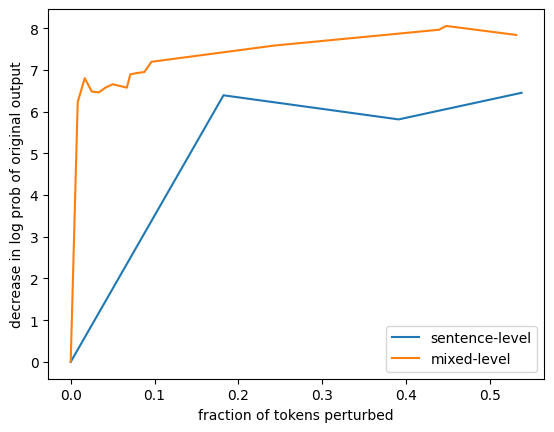

In [29]:
plt.plot(perturb_curve_sent.loc[0] - perturb_curve_sent)
plt.plot(perturb_curve_mixed.loc[0] - perturb_curve_mixed)
plt.xlabel("fraction of tokens perturbed")
plt.ylabel("decrease in log prob of original output")
plt.legend(["sentence-level", "mixed-level"])

In general, we are looking for perturbation curves to increase as more tokens are removed from the input. A higher perturbation curve is better because it indicates that the units identified by the explanation as important actually do have a larger effect on the LLM's output, and hence the explanation is more faithful to the LLM. 

For this example, the perturbation curve for mixed-level attributions rises more quickly from zero, indicating that mixed-level can identify the most important finer-grained units (i.e., words). However, sentence-level attributions may achieve a slightly larger decrease in log probability at higher perturbed fractions. Your results may vary however.